In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import random_statevector
from numpy import pi, random
import numpy as np 
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.primitives.sampler import Sampler 
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit_aer import QasmSimulator

from qiskit import transpile
%matplotlib inline

key a: 0
key b: 0
key c: 0
key d: 0


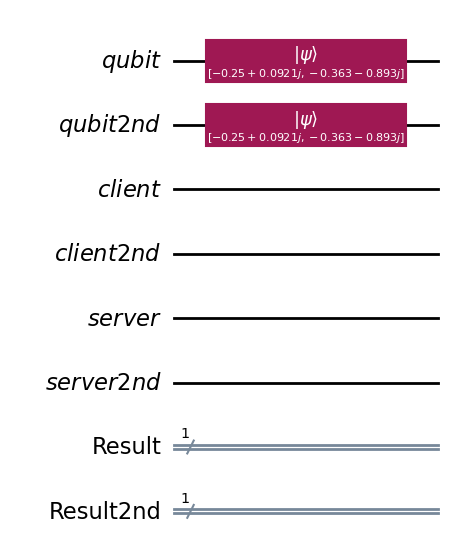

In [2]:
# Set up the circuit and registers
qubit = QuantumRegister(1, "qubit")
qubit2nd = QuantumRegister(1, "qubit2nd")
client = QuantumRegister(1, "client")
client2nd = QuantumRegister(1, "client2nd")
server = QuantumRegister(1, "server")
server2nd = QuantumRegister(1, "server2nd")
result = ClassicalRegister(1, "Result")
result2nd = ClassicalRegister(1, "Result2nd")
qc = QuantumCircuit(qubit, qubit2nd, client, client2nd, server, server2nd, result, result2nd) 

# Generate random keys for each qubit
a, b = random.randint(0, 1), random.randint(0, 1)
c, d = random.randint(0, 1), random.randint(0, 1)
# Prepare a random initial state |𝜓>
psi = random_statevector(2)
qc.initialize(psi.data, 0) 
qc.initialize(psi.data, 1) 

print(f"key a: {a}")
print(f"key b: {b}")
print(f"key c: {c}")
print(f"key d: {d}")

# Output the circuit for review
qc.draw('mpl')

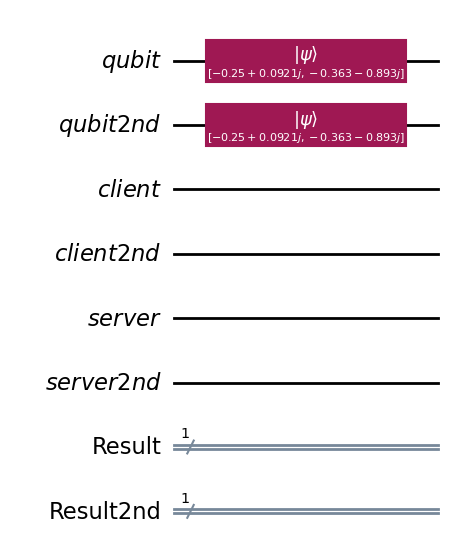

In [3]:
def encrypt_qubits(qc, qubit1, a, b):
    """Apply encryption with Pauli gates based on key bits a and b."""
    #for the first qubit 
    if a :
        qc.x(qubit1)
    if b :
        qc.z(qubit1)
# Encrypt the qubit

def encrypt_qubit2(qc, qubit2, c, d):
    """Apply encryption with Pauli gates based on key bits c and d."""
    if c:
        qc.x(qubit2)  # Apply X gate if c is 1
    if d:
        qc.z(qubit2)  # Apply Z gate if d is 1
        
encrypt_qubits(qc, 0, a, b)
encrypt_qubit2(qc, 1, c, d)

qc.draw('mpl')

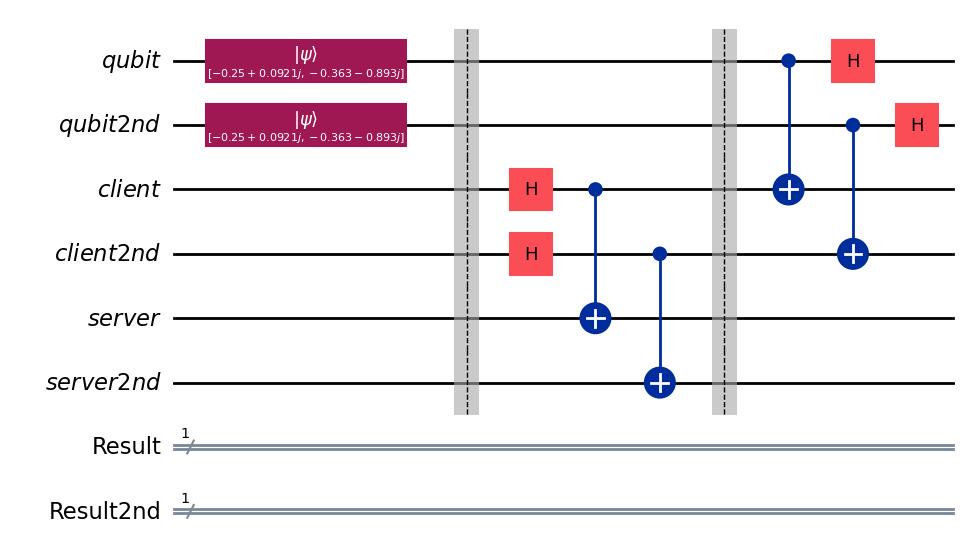

In [4]:
#prepare ebit used for teleportation 
qc.barrier()
qc.h(2)
qc.cx(2, 4)
qc.h(3)
qc.cx(3, 5)

#Client sending operation qubit 1
qc.barrier()
qc.cx(0, 2)
qc.h(0)
#Client sending operation to qubit 2
qc.cx(1, 3)
qc.h(1)

qc.draw('mpl')


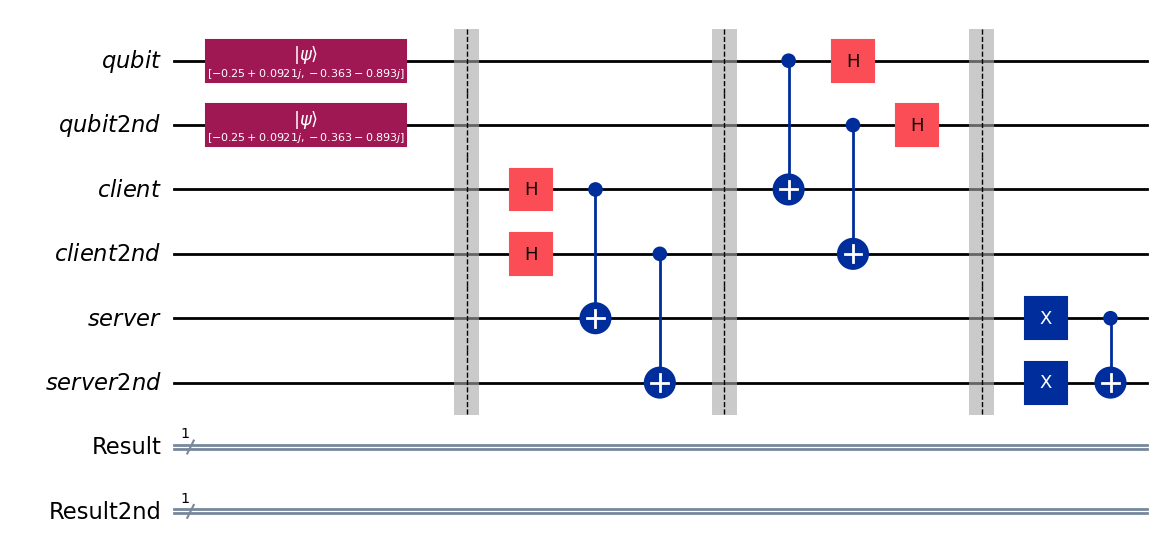

In [5]:
qc.barrier()
#define the server's operation function 
def server_operation(qc, qubit5, gate):
    """Apply a server operation based on a given identifier."""
    # Handling single qubit operations
    if gate == 'X':
        qc.x(qubit5)
    elif gate == 'Z':
        qc.z(qubit5)
    elif gate == 'H':
        qc.h(qubit5)
    elif gate == 'P':
        qc.p(np.pi/2, qubit5)  # Phase gate example
# Determine the gate for server operation based on the encryption keys
if a == 0 and b == 0:
    gate = 'X'  
elif a == 1 and b == 0:
    gate = 'Z' 
elif a == 0 and b == 1:
    gate = 'H'  
else:
    gate = 'P'  # Hadamard gate

def server_operation2(qc, qubit6, gate):
    """Apply a server operation based on a given identifier."""
    # Handling single qubit operations
    if gate == 'X':
        qc.x(qubit6)
    elif gate == 'Z':
        qc.z(qubit6)
    elif gate == 'H':
        qc.h(qubit6)
    elif gate == 'P':
        qc.p(np.pi/2, qubit6)  # Phase gate example
# Determine the gate for server operation based on the encryption keys
if a == 0 and b == 0:
    gate = 'X'  
elif a == 1 and b == 0:
    gate = 'Z' 
elif a == 0 and b == 1:
    gate = 'H'  
else:
    gate = 'P'  # Hadamard gate
    


server_operation(qc, 4, gate)
server_operation2(qc, 5, gate)
#server1 and server 2 connect via CNOT 
qc.cx(4, 5)


qc.draw('mpl')

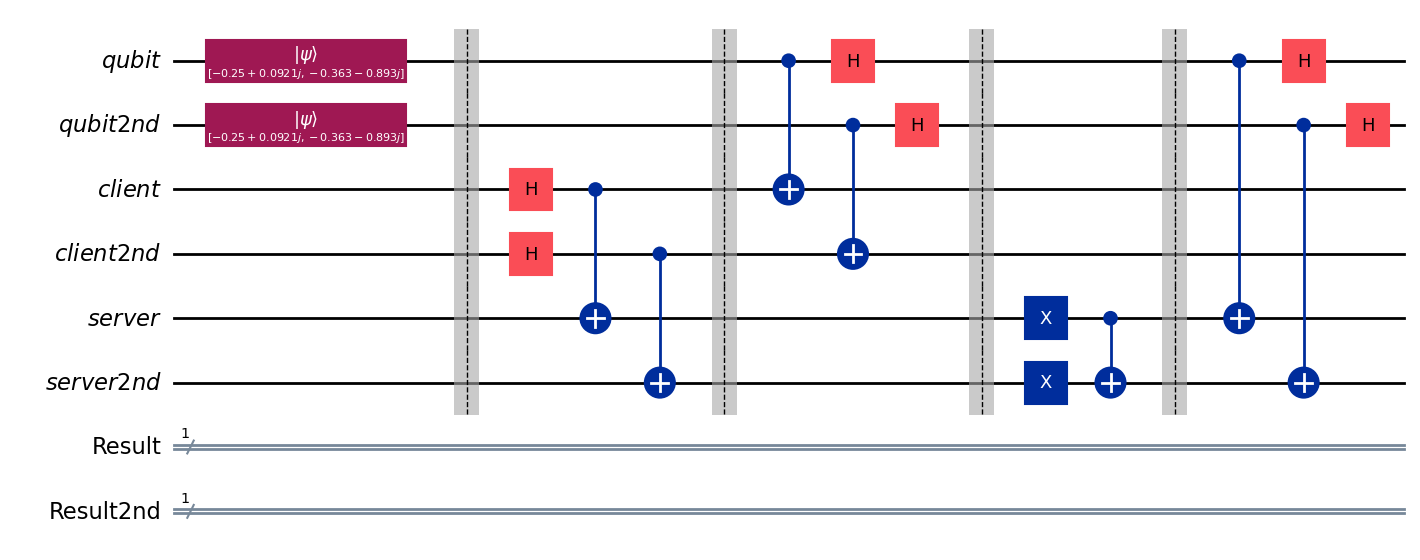

In [6]:
#Client sending operation 
qc.barrier()
qc.cx(0, 4)
qc.h(0)
#Client2 sending operation 
qc.cx(1, 5)
qc.h(1)

qc.draw('mpl')


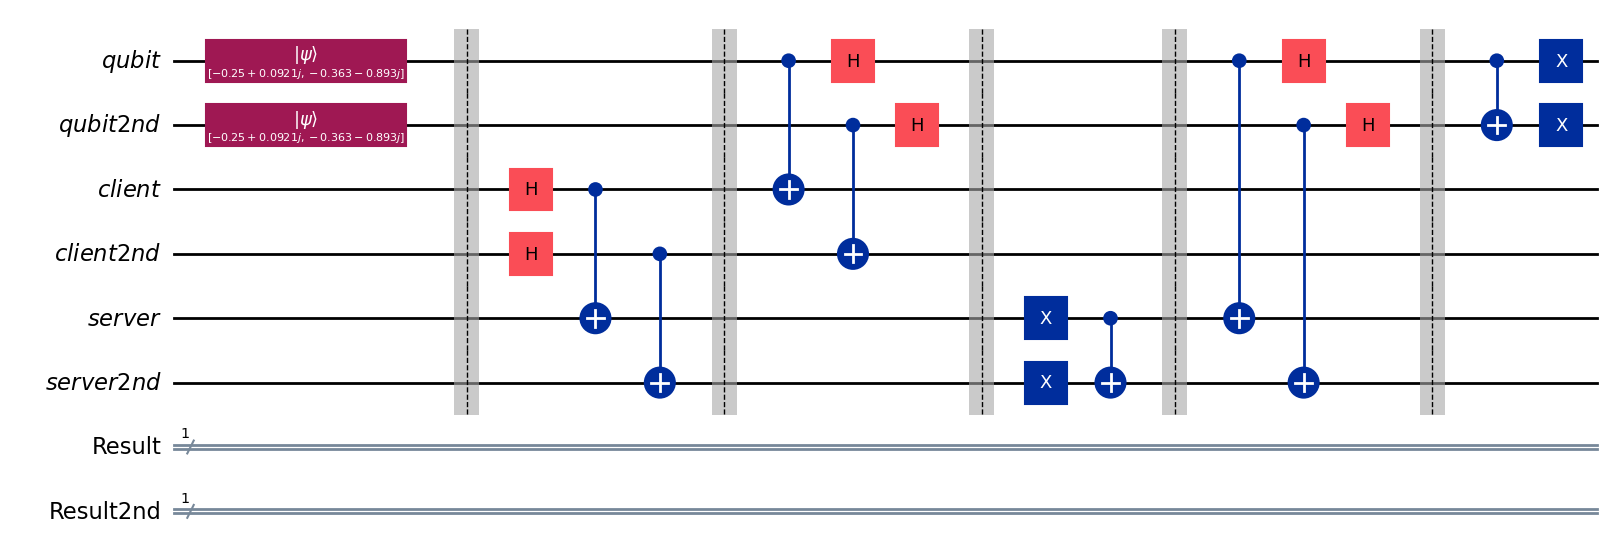

In [7]:
qc.barrier()
def decrypt(qc, qr, a, b, d):
    # Decide which scenario to apply based on a and b
    if a == 0 and b == 0:
        # Scenario 1: Xa Zb (not applied since both a and b are 0)
        qc.x(0)  # Apply an additional X for the example
    elif a == 1 and b == 0:
        # Scenario 2: Xa Zb (apply X since a is 1)
        qc.x(0)
        qc.z(0)  # Apply an additional Z for the example
    elif a == 0 and b == 1:
        # Scenario 3: Xb Za (apply X since b is 1)
        qc.x(0)
        qc.h(0)  # Apply H as additional gate
    else:
        # Scenario 4: Xa Za XOR b (both a and b are 1)
        qc.x(0)
        if b ^ d:  # This condition will be False since a == b == 1
            qc.z(0)
        qc.p(-np.pi/2, 0)  # Apply phase gate

def decrypt2nd(qc, qr, a, c, d):
    # Decide which scenario to apply based on a and b
    if a == 0 and b == 0:
        # Scenario 1: Xa Zb (not applied since both a and b are 0)
        qc.x(1)  # Apply an additional X for the example
    elif a == 1 and b == 0:
        # Scenario 2: Xa Zb (apply X since a is 1)
        qc.x(1)
        qc.z(1)  # Apply an additional Z for the example
    elif a == 0 and b == 1:
        # Scenario 3: Xb Za (apply X since b is 1)
        qc.x(1)
        qc.h(1)  # Apply H as additional gate
    else:
        # Scenario 4: Xa Za XOR b (both a and b are 1)
        if a ^ c:
            qc.x(1)
        if d:  # This condition will be False since a == b == 1
            qc.z(1)
        qc.p(-np.pi/2, 1)  # Apply phase gate


qc.cx(0, 1)  # Apply phase gate

decrypt(qc, 0, a, b, d)
decrypt2nd(qc, 1, a, c, d)

#measure out from the first 2 Qubits and 2 Classical Bits
qc.draw('mpl')

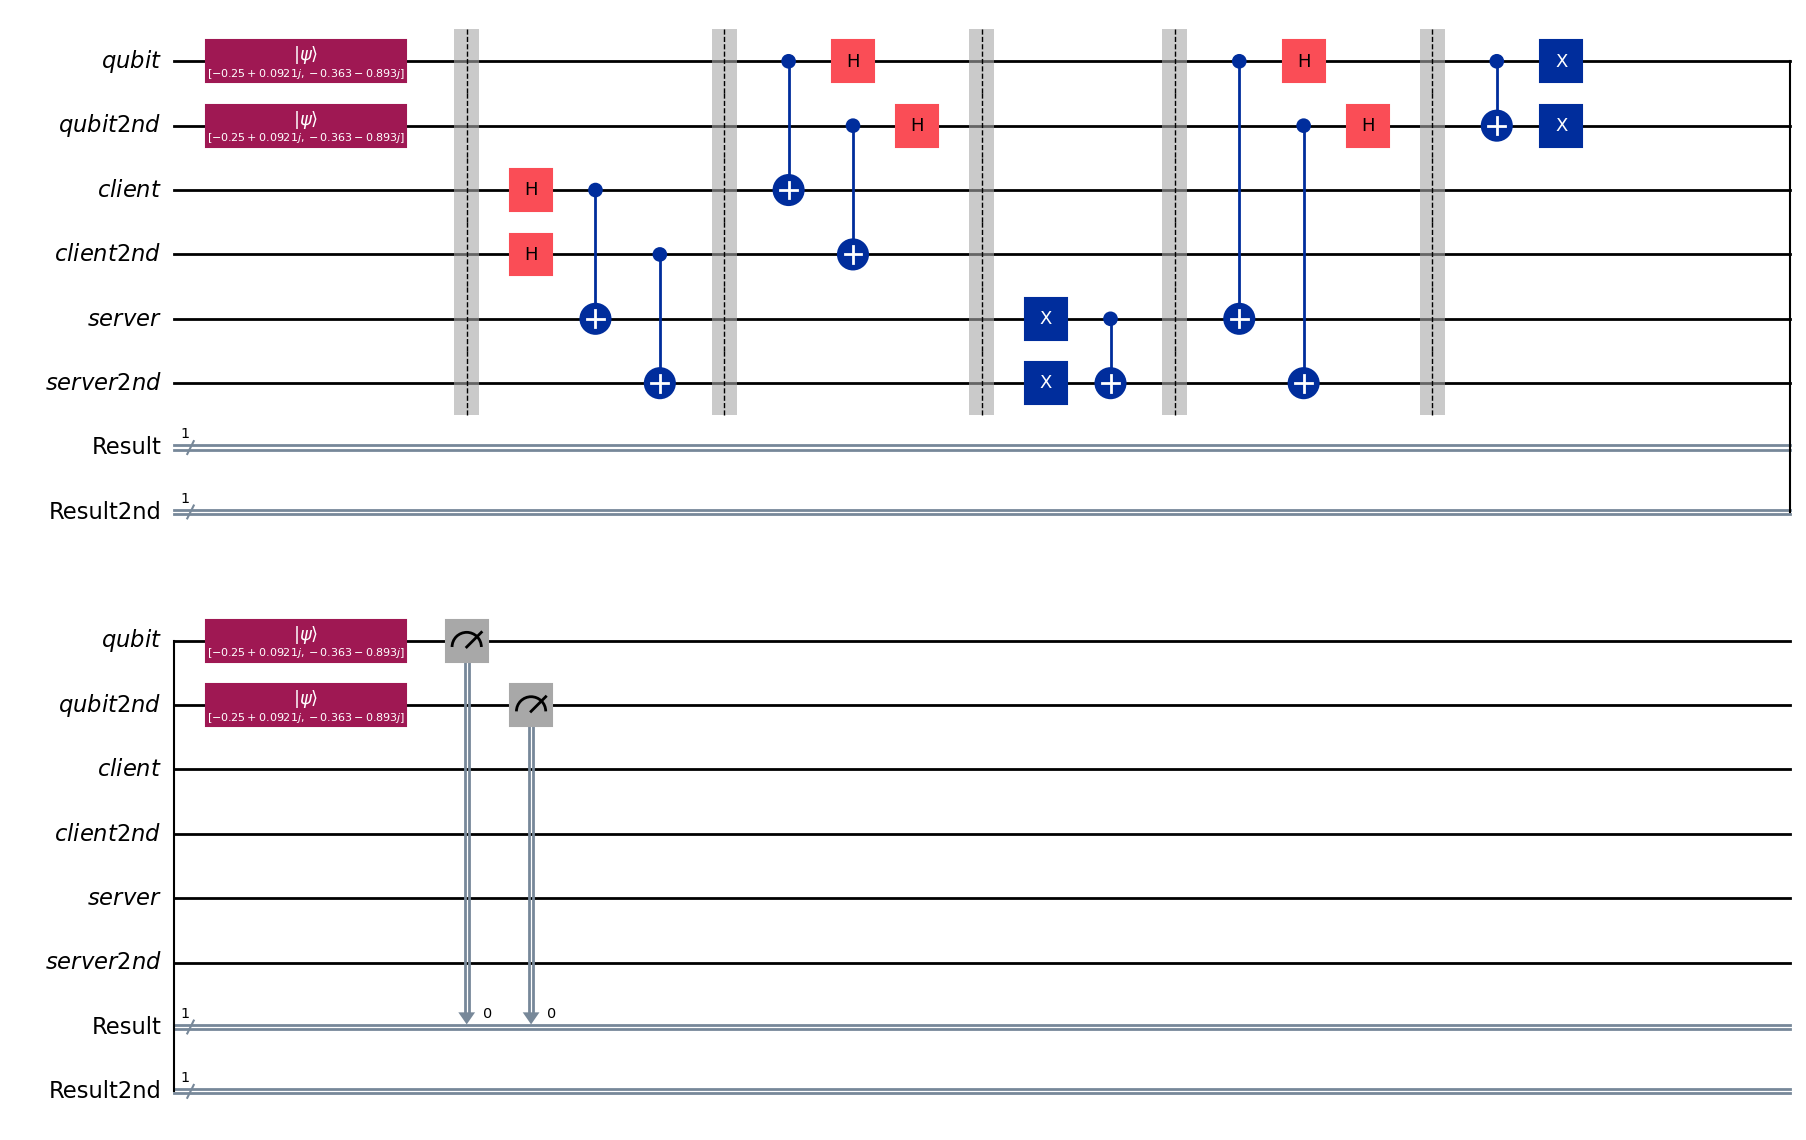

In [8]:
#Apply the inverse of the random unitary to B and measure 
qc.initialize(psi.data, qubit)
qc.initialize(psi.data, qubit2nd) 

result = ClassicalRegister(1, "Result")
result2nd = ClassicalRegister(1, "Result2nd")

#qc.add_resigter(result)
qc.measure(qubit, result)
qc.measure(qubit2nd, result)

qc.draw('mpl')

{'0 0': 66, '0 1': 934}


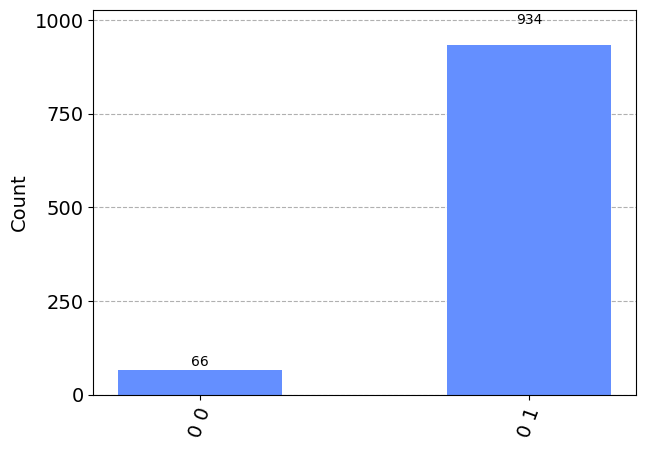

In [9]:
#Initialize a qasm simulator
simulator = QasmSimulator()

#Run and get the counts, which is a dictionary object 
result = simulator.run(qc, shots=1000).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

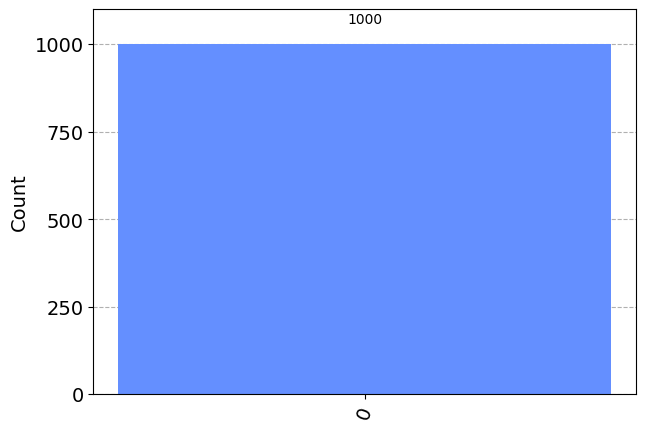

In [11]:
filtered_statistics = marginal_distribution(counts, [1])
display(plot_histogram(filtered_statistics))